In [1]:
import numpy as np
from lqfn.plain_qm import SchrodingerSystem
import lqfn.plotting
from numba import njit

Calculations of two correlators (propagator and cube propagator) for a harmonic oscillator using metropolis algorithm.

In [2]:
E_0 = 0.5
E_1 = 1.5
m = 1
omega_0 = 1

In [3]:
N=20
a=0.5
eps=1.4
N_cor=200
N_cfs=[25, 100, 1000, 10000]
N_copies = 100
N_view_points = 5

In [4]:
T=a*N

In [5]:
t = np.arange(N-1) * a
delta_E_exact = a*(E_1-E_0) #expected energy

In [6]:
@njit
def S_per_timeslice(j,x,a): # harm. osc. S
    N = x.shape[0]
    jp = (j+1)%N # next site
    jm = (j-1+N)%N # previous site
    return a*x[j]**2/2 + x[j]*(x[j]-x[jp]-x[jm])/a

In [7]:
harm_osc = SchrodingerSystem(T=T, N=N, S_per_timeslice=S_per_timeslice)

In [8]:
@njit
def compute_G(x,n):
    N = x.shape[0]
    g = 0
    for j in range(0,N):        
        g = g + x[j]*x[(j+n)%N]
    return g/N

In [9]:
def plot(avg, err, title, all_points=False):
    fig = lqfn.plotting.plot_delta_E(avg, err,
                       exact=delta_E_exact,
                       a=a,
                       title=title,
                       n=N_view_points if all_points is False else None)
    fig.show()

---
---

Calculation of $\Delta E$ for the correlation function 
$$
    G(t) = \frac{1}{N} \sum_j \langle x(t_j+t)x(t_j) \rangle
$$
for a one dimensional harmonic oscillator.
The errors are computed using error propagation.

In [10]:
delta_E_avgs = []
delta_E_errs = []
for N_cf in N_cfs:
    avg, err = harm_osc.compute_delta_E_pimc(compute_G, N_cf, N_cor, eps)
    delta_E_avgs.append(avg)
    delta_E_errs.append(err)

c:\Users\damia\Projects\path-integral-monte-carlo\src\lqfn\plotting.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


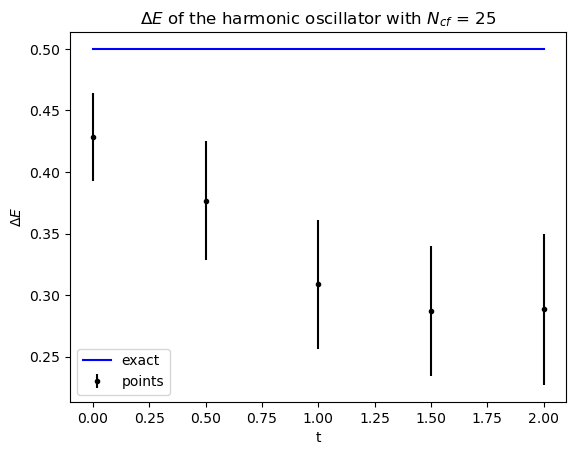

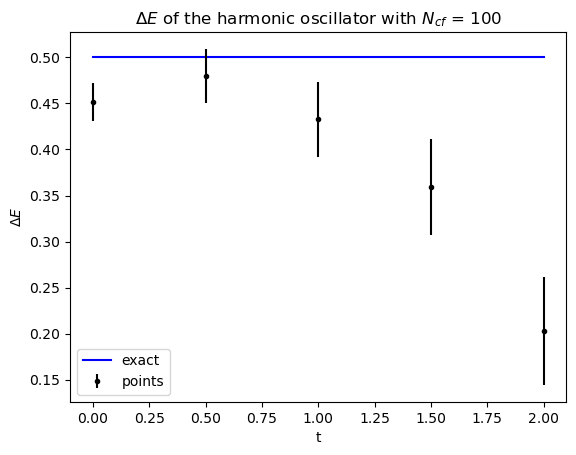

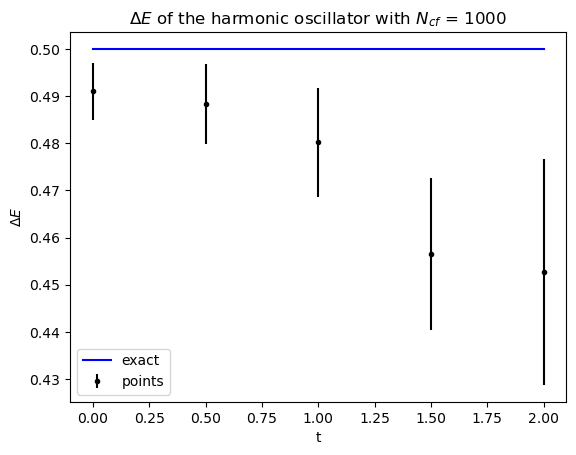

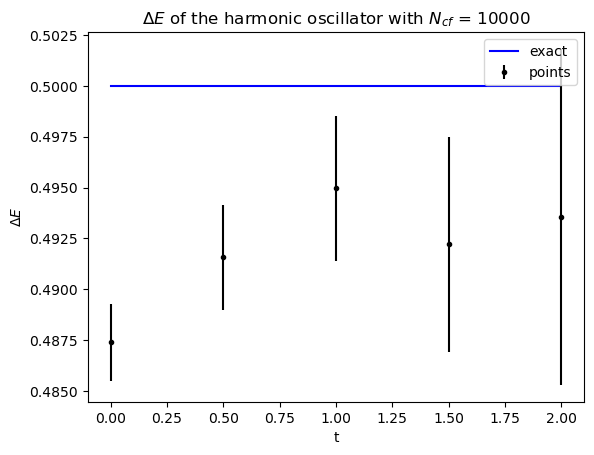

In [11]:
for i in range(len(delta_E_avgs)):
    plot(delta_E_avgs[i], delta_E_errs[i], title=f'$\Delta E$ of the harmonic oscillator with $N_{{cf}}$ = {N_cfs[i]}')

The error bars are unreliable, since we are not using bootstrap procedure yet

---
---

Calculation of $\Delta E$ for the correlation function 
$$
    G_{cube}(t) = \frac{1}{N} \sum_j \langle x^3(t_j+t)x^3(t_j) \rangle
$$
for a one dimensional harmonic oscillator. The errors are computed using error propagation.

In [12]:
@njit
def compute_G_cube(x,n):
    N = x.shape[0]
    g = 0
    for j in range(0,N):        
        g = g + (x[j]*x[(j+n)%N])**3
    return g/N

In [13]:
delta_E_avgs_cube = []
delta_E_errs_cube = []
for N_cf in N_cfs:
    avg, err = harm_osc.compute_delta_E_pimc(compute_G_cube, N_cf, N_cor, eps)
    delta_E_avgs_cube.append(avg)
    delta_E_errs_cube.append(err)

c:\Users\damia\Projects\path-integral-monte-carlo\src\lqfn\plotting.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


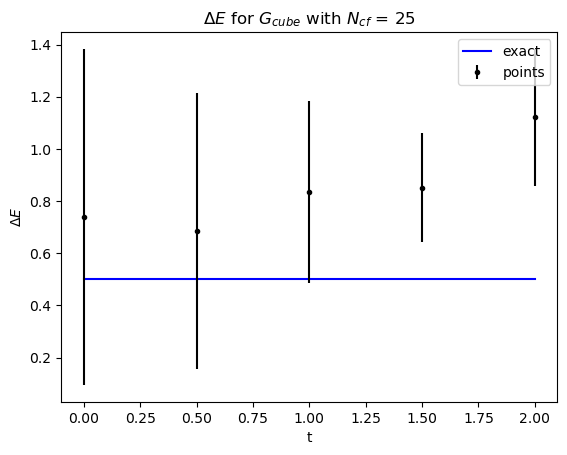

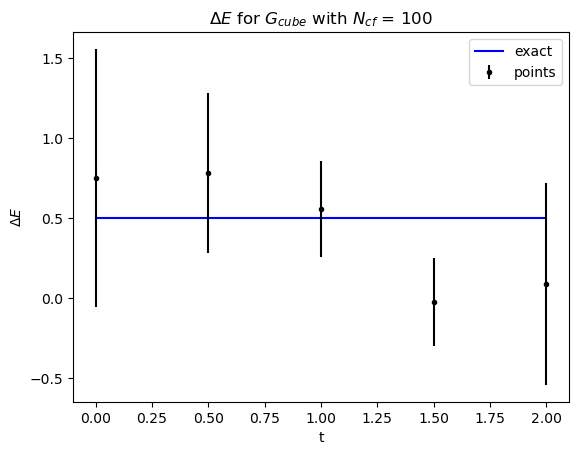

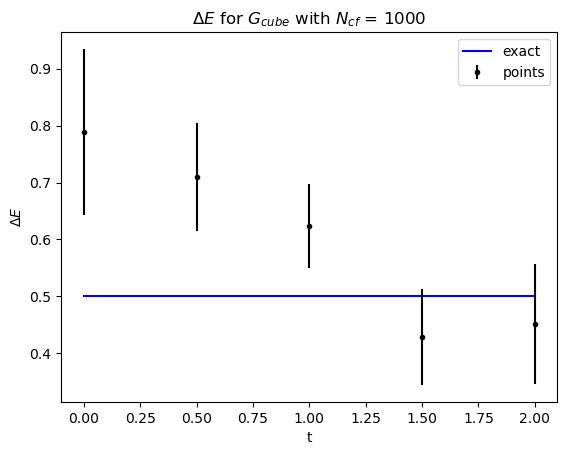

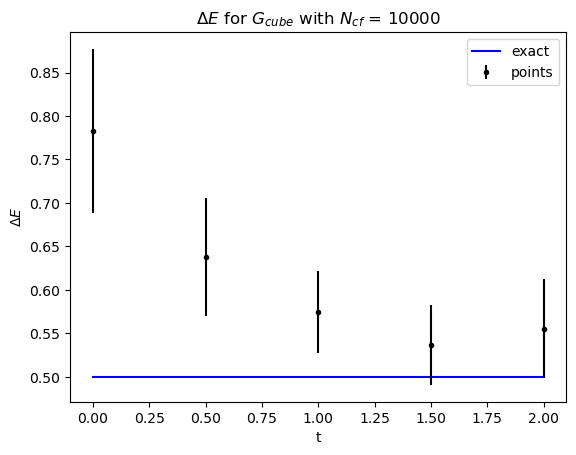

In [14]:
for i in range(len(delta_E_avgs_cube)):
    plot(delta_E_avgs_cube[i], delta_E_errs_cube[i], title=f'$\Delta E$ for $G_{{cube}}$ with $N_{{cf}}$ = {N_cfs[i]}')

We notice more clearly that the asymptotic value is reached from above.

---
---

Calculation of $\Delta E$ for the correlation function 
$$
    G(t) = \frac{1}{N} \sum_j \langle x(t_j+t)x(t_j) \rangle
$$
for a one dimensional harmonic oscillator. Now the errors are computed using bootstrap procedure.

In [33]:
delta_E_avg_bootstrap, delta_E_err_bootstrap = harm_osc.compute_delta_E_pimc(compute_G, N_cf=10000, N_cor=500, eps=eps, N_copies=N_copies)

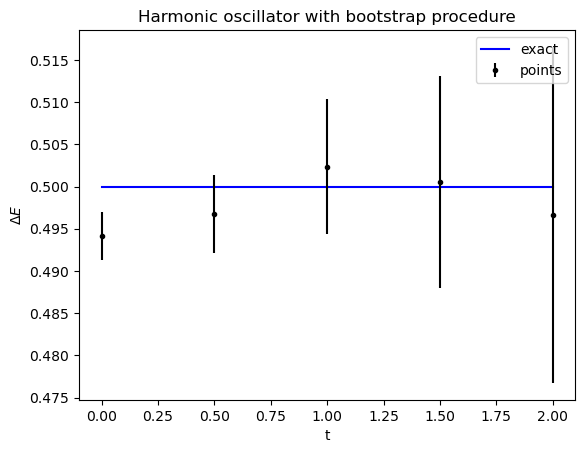

In [34]:
plot(delta_E_avg_bootstrap, delta_E_err_bootstrap, title='Harmonic oscillator with bootstrap procedure')

---
---

We observe that G is close to zero for $t = \frac{Na}{2} $, hence the error associated to G is higher in this region due to the error propagation formula, and the same behaviour happens with bootstrap procedure, consistently enough.

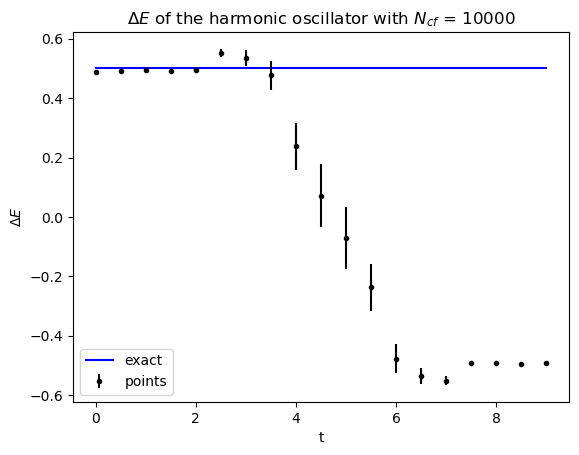

In [17]:
plot(delta_E_avgs[-1], delta_E_errs[-1], title=f'$\Delta E$ of the harmonic oscillator with $N_{{cf}}$ = {N_cfs[-1]}', all_points=True)

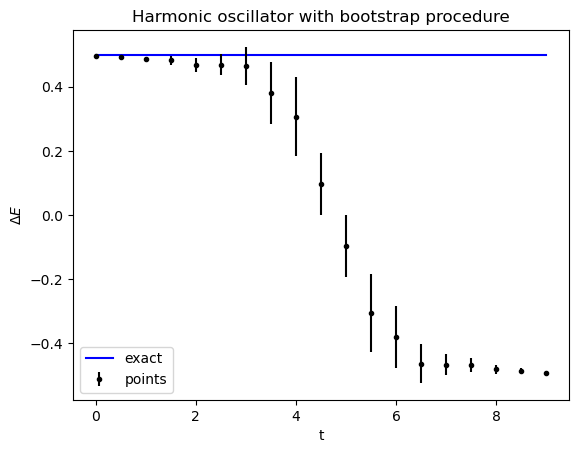

In [18]:
plot(delta_E_avg_bootstrap, delta_E_err_bootstrap, title='Harmonic oscillator with bootstrap procedure', all_points=True)

---
---

Running of the metropolis simulation using $N_{cor}$=1.

In [19]:
delta_E_avg_lowtherm, delta_E_err_lowtherm = harm_osc.compute_delta_E_pimc(compute_G, N_cf=1000, N_cor=1, eps=eps, N_copies=N_copies, thermalization_its=0)

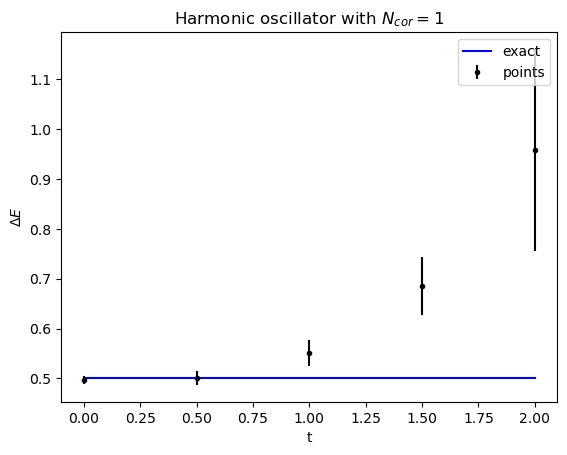

In [20]:
plot(delta_E_avg_lowtherm, delta_E_err_lowtherm, title='Harmonic oscillator with $N_{cor} = 1$')

The errors are unrelaible as expected

---

Apply binning procedure

In [21]:
delta_E_avg_binning, delta_E_err_binning = harm_osc.compute_delta_E_pimc(compute_G, N_cf=1000, N_cor=1, eps=eps, N_copies=N_copies, bin_size=10, thermalization_its=0)

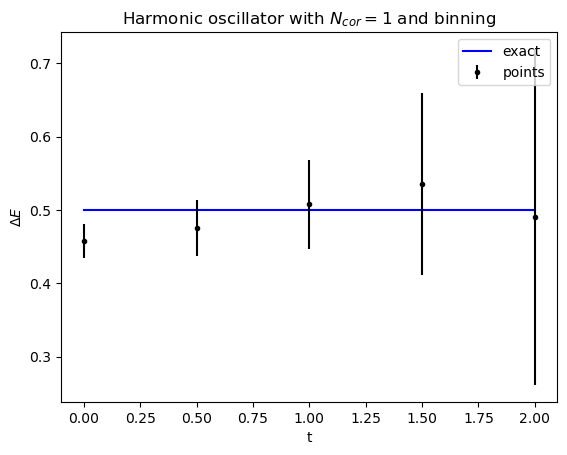

In [22]:
plot(delta_E_avg_binning, delta_E_err_binning, title='Harmonic oscillator with $N_{cor} = 1$ and binning')

---
---

Harmonic oscillator with improved action

The new action is 
$$
    S_{imp}[x] = \sum_{j=0}^{N-1} a  \left[-\frac{1}{2}x_j \left(\Delta^{(2)} -a^2 \frac{(\Delta^{(2)})^2}{12} -1 \right)x_j \right]
$$
where $\Delta^{(2)}$ is the discretize second derivative. meaning that
$$
    \Delta^{(2)} x_j = \frac{x_{j+1}-2x_j+x_{j+1}}{a^2}
$$

In [23]:
@njit
def S_per_timeslice_improved(j,x,a): # harm. osc. S
    N = x.shape[0]
    jpp = (j+2)%N
    jp = (j+1)%N
    jm = (j-1+N)%N
    jmm = (j-2+N)%N
    Sj = -0.5*x[j]*(2*x[jp] - 2*x[j] + 2*x[jm] - (2*x[jpp] - 8*x[jp] + 6*x[j] - 8*x[jm] + 2*x[jmm])/12)/a + a*0.5*x[j]**2
    return Sj

In [24]:
harm_osc_imp = SchrodingerSystem(T=T, N=N, S_per_timeslice=S_per_timeslice_improved)

In [25]:
delta_E_avg_imp, delta_E_err_imp = harm_osc_imp.compute_delta_E_pimc(compute_G, N_cf=10000, N_cor=N_cor, eps=eps, N_copies=N_copies)

c:\Users\damia\Projects\path-integral-monte-carlo\src\lqfn\plotting.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


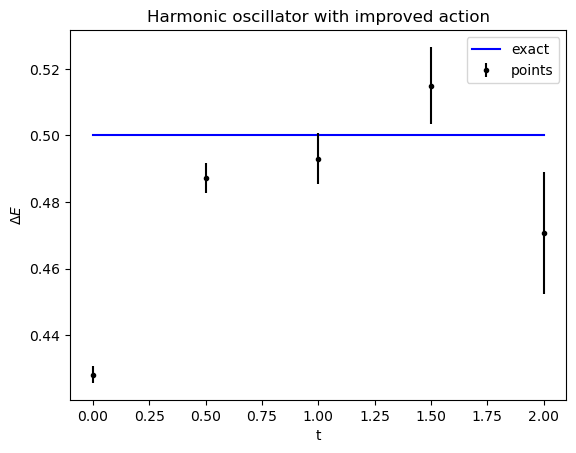

In [26]:
plot(delta_E_avg_imp, delta_E_err_imp, title='Harmonic oscillator with improved action')

The asymptotic value is approached from below, as expected from the existance of ghost states with negative norm.

---
---

Change variables to remove numerical ghosts, and recompute the action

In [27]:
@njit
def S_per_timeslice_noghost(j, x, a):
    N = x.shape[0]
    jp = (j+1)%N
    jm = (j-1+N)%N
    return a*(-1/2*m*x[j]*(2*x[jm] + 2*x[jp] - 2*x[j])/a**2 + 1/2*m*omega_0**2*x[j]**2*(1+(a*omega_0)**2/12))

In [28]:
harm_osc_noghost = SchrodingerSystem(T=a*N, N=N, S_per_timeslice=S_per_timeslice_noghost)

In [29]:
delta_E_avg_noghost, delta_E_err_noghost = harm_osc_noghost.compute_delta_E_pimc(compute_G, N_cf=10000, N_cor=500, eps=eps, N_copies=N_copies)

c:\Users\damia\Projects\path-integral-monte-carlo\src\lqfn\plotting.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


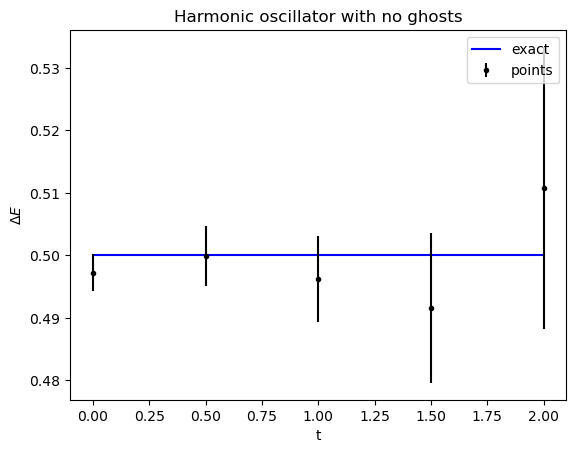

In [30]:
plot(delta_E_avg_noghost, delta_E_err_noghost, title="Harmonic oscillator with no ghosts")